# Darts Playground

This notebook provodes a general workflow for forecasting with Darts using the core functionality of the library.

In [53]:
import pandas as pd
import datetime
from darts import TimeSeries
from darts.utils.statistics import plot_acf, plot_pacf, plot_hist
import matplotlib.pyplot as plt
from darts.models import LinearRegressionModel, XGBModel
from darts.metrics import mape


## Load the Data

In [2]:
input = pd.read_csv("./data/us48.csv")
input["period"] = pd.to_datetime(input["period"])
end = input["period"].max().floor(freq = "d")  - datetime.timedelta(hours = 1)
input = input[input["period"] <= end]
input.tail(6)

,period,respondent,respondent-name,type,type-name,value,value-units
77893,2024-05-19 18:00:00,US48,United States Lower 48,D,Demand,478166.66,megawatthours
77894,2024-05-19 19:00:00,US48,United States Lower 48,D,Demand,491234.66,megawatthours
77895,2024-05-19 20:00:00,US48,United States Lower 48,D,Demand,503449.55,megawatthours
77896,2024-05-19 21:00:00,US48,United States Lower 48,D,Demand,515891.87,megawatthours
77897,2024-05-19 22:00:00,US48,United States Lower 48,D,Demand,526446.11,megawatthours
77898,2024-05-19 23:00:00,US48,United States Lower 48,D,Demand,530963.66,megawatthours


## Converting the Pandas DataFrame to Darts Time Series Object

In [3]:
df = input[["period", "value"]].sort_values(by = ["period"])
df

,period,value
0,2015-07-01 05:00:00,162827.00
1,2015-07-01 06:00:00,335153.00
2,2015-07-01 07:00:00,333837.00
3,2015-07-01 08:00:00,398386.00
4,2015-07-01 09:00:00,388954.00
...,...,...
77894,2024-05-19 19:00:00,491234.66
77895,2024-05-19 20:00:00,503449.55
77896,2024-05-19 21:00:00,515891.87
77897,2024-05-19 22:00:00,526446.11


In [4]:
ts = TimeSeries.from_dataframe(df, time_col= "period", value_cols= "value")
print(type(ts))

<class 'darts.timeseries.TimeSeries'>


<Axes: xlabel='period'>

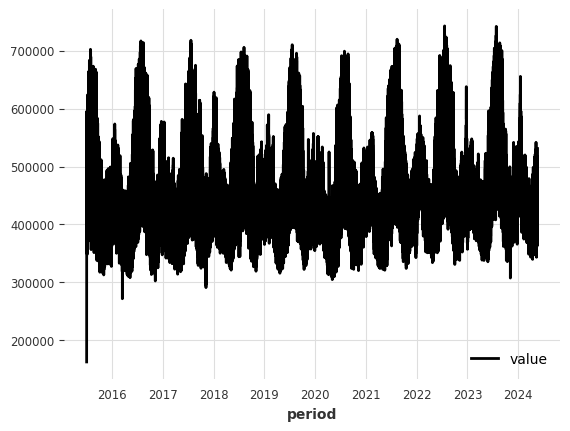

In [5]:
ts.plot()

For the model training we will use the last 2 years:

In [6]:
train_length = 24 * 365 * 2
df = input[["period", "value"]].sort_values(by = ["period"])
df = df.iloc[-(train_length):]
df

,period,value
60379,2022-05-21 00:00:00,555281.00
60380,2022-05-21 01:00:00,539728.00
60381,2022-05-21 02:00:00,525810.00
60382,2022-05-21 03:00:00,505170.00
60383,2022-05-21 04:00:00,480875.00
...,...,...
77894,2024-05-19 19:00:00,491234.66
77895,2024-05-19 20:00:00,503449.55
77896,2024-05-19 21:00:00,515891.87
77897,2024-05-19 22:00:00,526446.11


<Axes: xlabel='period'>

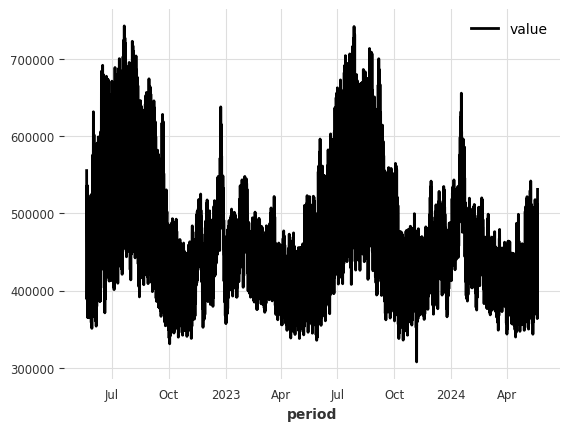

In [7]:
ts = TimeSeries.from_dataframe(df, time_col= "period", value_cols= "value")
ts.plot()

# Time Series Exploratory Analysis

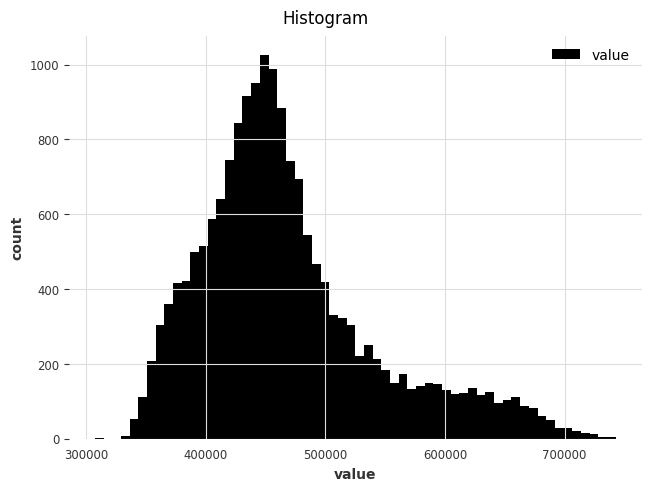

In [8]:
plot_hist(ts, bins = 60)

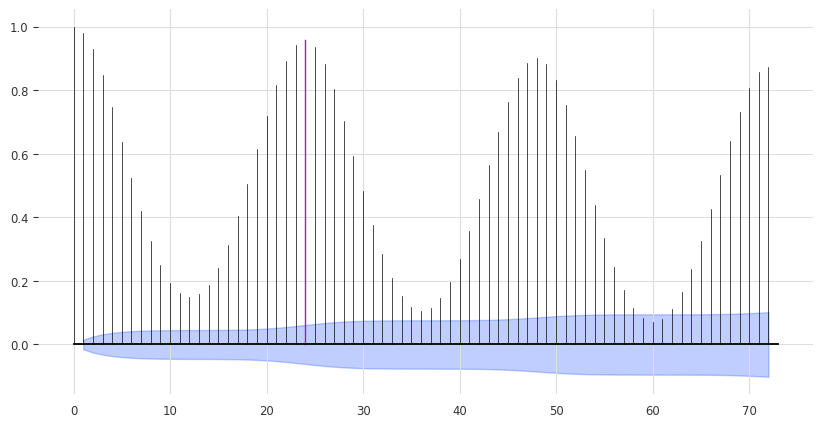

In [9]:
plot_acf(ts, m = 24, max_lag = 72, alpha = 0.05)

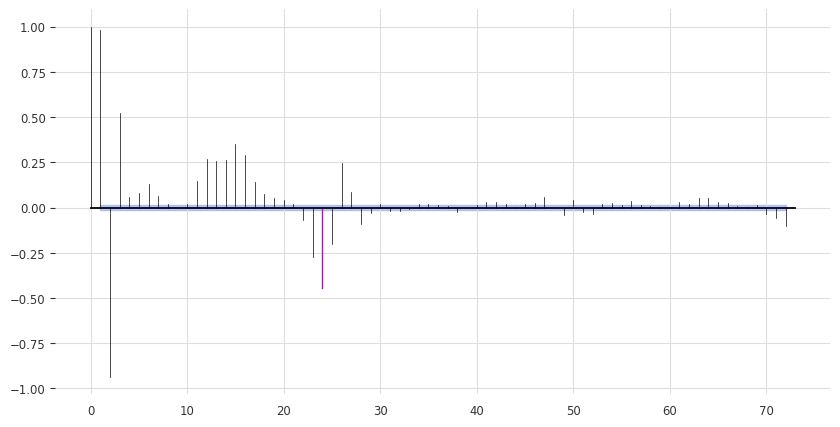

In [10]:
plot_pacf(ts, m = 24, max_lag = 72, alpha = 0.05)

<Axes: xlabel='period'>

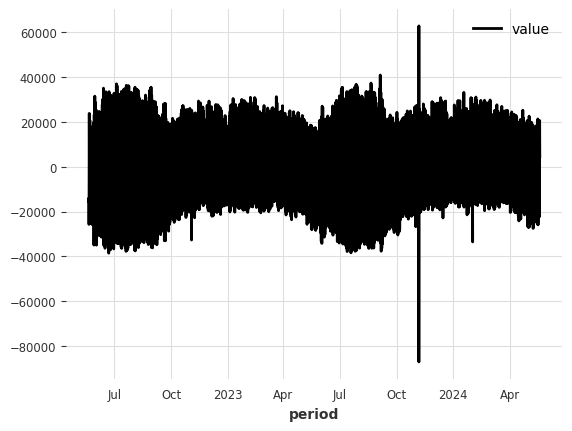

In [11]:
ts.diff().plot()

## Training Forecasting Model

In [42]:
test_length = 72
pi = 0.05
lower = pi/2
upper = 1 - pi/2
lags=[-1, -23,-24, -25, -48]
seed = 12345
num_samples = 100

In [43]:
train, val = ts[:-test_length], ts[-test_length:]

In [44]:
lm_md = LinearRegressionModel(lags = lags,
                     likelihood= "quantile", 
                     random_state = seed,
                     quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

In [45]:
lm_md.fit(train)


LinearRegressionModel(lags=[-1, -23, -24, -25, -48], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=quantile, quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95], random_state=12345, multi_models=True, use_static_covariates=True)

In [46]:
prediction = lm_md.predict(test_length, num_samples= num_samples)

In [72]:
val._time_index[0]
val.all_values().min()

363643.89

Text(2024-05-17 00:00:00, 345461.6955, 'MAPE = 2.38%')

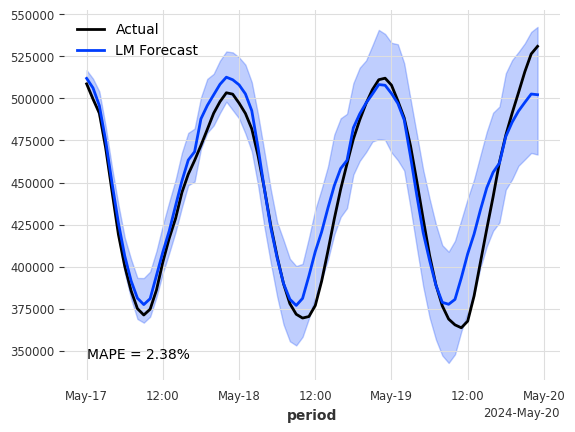

In [74]:
m = "MAPE = {:.2f}%".format(mape(val, prediction))
val.plot(label = "Actual")
prediction.plot(label="LM Forecast")
plt.legend()
plt.text(val._time_index[0], 0.95 *val.all_values().min(), m, fontsize = 10)


Training XGBoost model:

In [18]:
xg_md = XGBModel(lags = lags,
                 likelihood= "quantile", 
                 random_state = seed,
                 quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

In [19]:
xg_md.fit(train)

XGBModel(lags=[-1, -23, -24, -25, -48], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=quantile, quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95], random_state=12345, multi_models=True, use_static_covariates=True)

In [20]:
prediction_xg = xg_md.predict(test_length, num_samples = num_samples)

Text(2024-05-17 00:00:00, 345461.6955, 'MAPE = 2.65%')

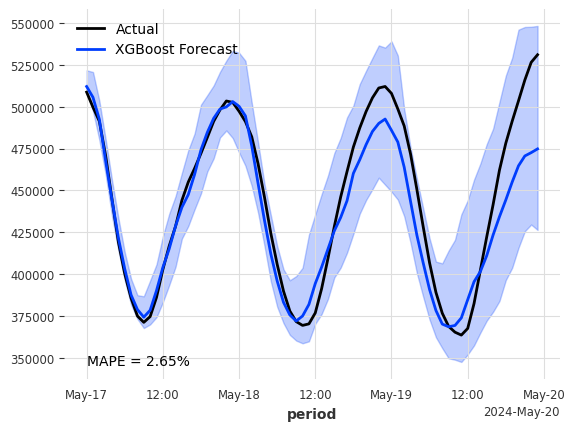

In [75]:
m_xg = "MAPE = {:.2f}%".format(mape(val, prediction_xg))
val.plot(label = "Actual")
prediction_xg.plot(label="XGBoost Forecast")
plt.legend()
plt.text(val._time_index[0], 0.95 *val.all_values().min(), m_xg, fontsize = 10)

In [22]:
lags_2=[-1,-2, -3,-4, -23,-24, -25, -48]

xg_md_2 = XGBModel(lags = lags_2,
                 likelihood= "quantile", 
                 random_state = seed,
                 quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

In [23]:
xg_md_2.fit(train)
prediction_xg_2 = xg_md_2.predict(test_length, num_samples = num_samples)

Text(2024-05-17 00:00:00, 345461.6955, 'MAPE = 1.84%')

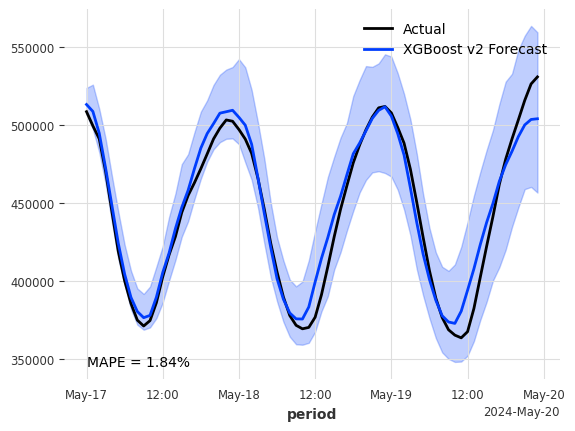

In [77]:
m_xg2 = "MAPE = {:.2f}%".format(mape(val, prediction_xg_2))
val.plot(label = "Actual")
prediction_xg_2.plot(label="XGBoost v2 Forecast")
# plt.legend()
plt.text(val._time_index[0], 0.95 *val.all_values().min(), m_xg2, fontsize = 10)
